# Exploratory Data Analysis - Proportionality of NL and SC
> Prototyping D: Code Completion

This notebook focuses on showcasing the proportion of natural language elements and source code elements in both the prompts and the generated code across the four datasets.

*Notebook Structure*
- Notebook parameters
- Source Code
    - Imports
    - Data Loading
    - Data Processing
- Experiment [1.4.0.2]

*General Instructions*
* Collapse cells by tittle to improve the navigation
* Before running the experiments, it is required to have tagged_rationales and sampling_results of each dataset.
* Read description on each experiment for further instructions

In [1]:
def param_default():
    return {
        'model': 'codeparrot',
        'modality' : 'nl_sc',
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        'sampling_results': '/workspaces/code-rationales/data/sampling',
        'tagged_rationales': '/workspaces/code-rationales/data/tagged_rationales',
        'num_experiments': 30,
        'num_samples': 100,
    }
    
params = param_default()

## Source Code

### Imports

In [2]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
import json
import os.path
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format

### Data Loading

In [3]:
### Retrieve experiments
def retrieve_df_tagged_rationales(dataset_name):
    get_experiment_path =  lambda exp: params['tagged_rationales'] + '/' + params['modality'] + '/' + dataset_name +'_exp_' + str(exp) +'.csv'
    experiment_paths = [get_experiment_path(exp) for exp in range(params['num_experiments'])]
    df_tagged_exp_rationales = []
    for experiment_path in experiment_paths:
        df_tagged_exp_rationales.append(pd.read_csv(experiment_path, index_col=0))
    return df_tagged_exp_rationales

### Data Processing

In [4]:
### token types by sample
def get_sample_types_distribution(df_tagged_tokens):
    nl_tokens_count = 0 
    sc_tokens_count = 0
    for token_tags in df_tagged_tokens['tags']:
        nl_tokens_count += sum(1 for tag in eval(token_tags) if tag[0] == 'nl')
        sc_tokens_count+= sum(1 for tag in eval(token_tags) if tag[0] == 'sc')
    return nl_tokens_count, sc_tokens_count

In [5]:
## token type distributions by experiment
def get_experiment_token_type_counts(df_exp, df_sampled_inputs):
    exp_prompt_nl_tokens_count = []
    exp_prompt_sc_tokens_count = []
    exp_generated_nl_tokens_count = []
    exp_generated_sc_tokens_count = []
    for sample_id in range(0, params['num_samples']):
        df_prompt_rationales = df_exp.loc[df_exp['from_seq_id']==sample_id].head(len(eval(df_sampled_inputs['input_ids'][sample_id])))
        df_generated_rationales = df_exp.loc[df_exp['from_seq_id']==sample_id].iloc[len(eval(df_sampled_inputs['input_ids'][sample_id])):]
        prompt_nl_tokens_count, prompt_sc_tokens_count = get_sample_types_distribution(df_prompt_rationales)
        generated_nl_tokens_count, generated_sc_tokens_count = get_sample_types_distribution(df_generated_rationales)
        exp_prompt_nl_tokens_count.append(prompt_nl_tokens_count)
        exp_prompt_sc_tokens_count.append(prompt_sc_tokens_count)
        exp_generated_nl_tokens_count.append(generated_nl_tokens_count)
        exp_generated_sc_tokens_count.append(generated_sc_tokens_count)
    return np.median(exp_prompt_nl_tokens_count), np.median(exp_prompt_sc_tokens_count), np.median(exp_generated_nl_tokens_count), np.median(exp_generated_sc_tokens_count)

In [6]:
def get_token_type_counts(df_exp_tagged_rationales, df_sampled_inputs):
    prompt_nl_tokens_count = []
    prompt_sc_tokens_count = []
    generated_nl_tokens_count = []
    generated_sc_tokens_count = []
    for experiment in df_exp_tagged_rationales:
        exp_prompt_nl_tokens, exp_prompt_sc_tokens, exp_generated_nl_tokens, exp_generated_sc_tokens = get_experiment_token_type_counts(experiment, df_sampled_inputs)
        prompt_nl_tokens_count.append(exp_prompt_nl_tokens), prompt_sc_tokens_count.append(exp_prompt_sc_tokens), generated_nl_tokens_count.append(exp_generated_nl_tokens), generated_sc_tokens_count.append(exp_generated_sc_tokens)
    return np.median(prompt_nl_tokens_count), np.median(prompt_sc_tokens_count), np.median(generated_nl_tokens_count), np.median(generated_sc_tokens_count)

In [7]:
def create_token_types_counting_df():
    df_token_types = pd.DataFrame(columns=['dataset', 'token_type', 'count'])
    for dataset_id, dataset in params['datasets'].items():
        df_sampled_inputs = pd.read_csv( param_default()['sampling_results'] + '/' + params['model'] + '/' + dataset +'.csv', index_col=0)
        df_exp_tagged_rationales = retrieve_df_tagged_rationales(dataset)
        prompt_nl_tokens_count, prompt_sc_tokens_count, generated_nl_tokens_count, generated_sc_tokens_count = get_token_type_counts(df_exp_tagged_rationales, df_sampled_inputs)
        df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'PMT_NL', 'count': prompt_nl_tokens_count}, ignore_index=True)
        df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'PMT_SC', 'count': prompt_sc_tokens_count}, ignore_index=True)
        df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'GEN_NL', 'count': generated_nl_tokens_count}, ignore_index=True)
        df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'GEN_SC', 'count': generated_sc_tokens_count}, ignore_index=True)
    return df_token_types

## Experiment [1.4.0.2]
**Frequencies of token types in prompts and generated code**

*Research Question: What is the proportion of NL and SC elements in the prompts and generated code?*

General Instructions: Execute this experiment per dataset separately
- Change ```model``` in ```param_default```, indicating the name of the model used for inference
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: create dataframe of frequencies of NL and SC tokens
- Iterates over all sampling results for each dataset.
- Retrieves the tagged rationales for each set of sampling results.
- Counts the number of natural language (NL) and source code (SC) tokens in both the prompts and the generated code for each result.
- Since for each sample 30 different generations are executed, calculates the median of these counts.
- Returns a dataframe containing information about the datasets, token types, and their counts. 

In [8]:
df_token_types = create_token_types_counting_df()

#### Step 2: prints the summary of countings

In [9]:
df_token_types

,dataset,token_type,count
0,SG_BD,PMT_NL,9.50
1,SG_BD,PMT_SC,92.50
2,SG_BD,GEN_NL,12.00
3,SG_BD,GEN_SC,125.25
4,DC_SG_BD,PMT_NL,39.00
5,DC_SG_BD,PMT_SC,182.50
6,DC_SG_BD,GEN_NL,41.50
7,DC_SG_BD,GEN_SC,476.25
8,DC_SG,PMT_NL,28.50
9,DC_SG,PMT_SC,39.00


#### Step 3: prints the countings in a bar plot

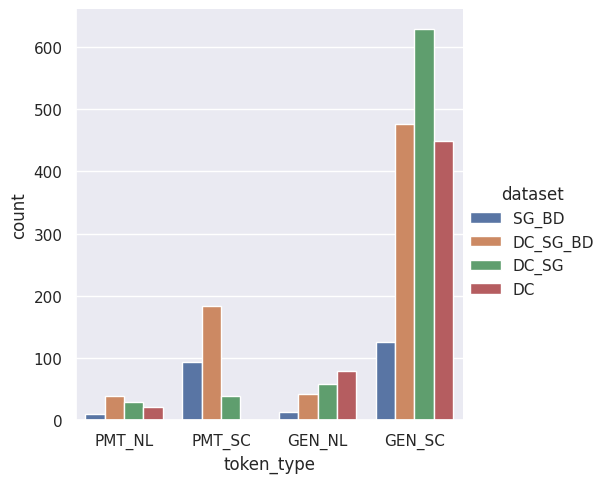

In [10]:
g = sns.catplot(x='token_type', y='count', hue='dataset', data=df_token_types, kind='bar', height=5, aspect=1)

### Prototyping results
The following subsections show the generated bar plots for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```param_default``` at the beginning of the notebook and run the notebook until this point. 
- ```'model'```
- ```'modality'```

### Results
- The proportionality of the generated code is bigger than natural language. 
- The same proportionality is preserved for the prompts. Code > NL
- Just documentation as a prompt activates the generation of more natural language and source code tokens. 
- The prompt combination of DC_SG seems to have a greater proportionality of source code tokens (GEN-SC) in the generated output. This uneven proportionality can be explained since this setting in the prompt (ie., DC_SG and DC_SG_BD) would contain more information than the prompt combination SG_BD and DC. DC_SG exhibits a larger number of GEN_SC tokens in comparison to DC_SG_BD since by adding BD to DC_SG the prompt is more contextualized. Therefore, BD is now conditioning the generation to trigger more code tokens.
- There are some generation scenarios where GEN_SC does not correspond with the definition of a method, for instance a variable benign defined right after the docstring, not containing in a method. Since M1 learnt how to complete functions from the training set, this observation is reflected by the results observed in DC, where GEN_SC do not start by defining a function, hence their number would be smaller than the other cases. 
- Since the model was training on source code only, we argue that DC_SG and DC_SG_BD will have more room to create source code related tokens, encapsulated within a function. 



![token_types_frequencies.jpg](captures/frequencies/token_types_frequencies.jpg)